In [ ]:
from transformers import pipeline
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity


In [17]:
#model = AutoModel.from_pretrained( "gpt2", output_hidden_states=True)  #load pretrained from Hugging Face
model = AutoModelForCausalLM.from_pretrained("gpt2", output_attentions=True, output_hidden_states=True)

tokenizer = AutoTokenizer.from_pretrained("gpt2")                     #trasforma input in token

c:\Users\angel\Desktop\LCP_B_GPT2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
c:\Users\angel\Desktop\LCP_B_GPT2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


In [18]:
# Initialize the text generation pipeline
generator = pipeline("text-generation", model="gpt2", device=-1)  # Use device=0 for GPU, or device=-1 for CPU
output = generator("Q: What is the capital of France? A: Paris. Q: What is the capital of Italy? A:", max_length=30, temperature=0.9, num_return_sequences=3)

#IDK se è utile ma ci sono modi per forzare le parole che genera. 

# Print the generated text
for idx, generated_text in enumerate(output):
    print(f"Generated Text {idx + 1}: {generated_text['generated_text']}")


Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Text 1: Q: What is the capital of France? A: Paris. Q: What is the capital of Italy? A: Rome. Q: What is
Generated Text 2: Q: What is the capital of France? A: Paris. Q: What is the capital of Italy? A: Naples. Q: What is
Generated Text 3: Q: What is the capital of France? A: Paris. Q: What is the capital of Italy? A: Florence. Q: What is


In [19]:

#text = ["Q: What is the capital of France? A: Paris. Q: What is the capital of Italy? A:"]
text=["pear", "apple", "orange", "banana"]  #you can add more input

"""If the tokenizer being used doesn't already have a pad_token, this line assigns the eos_token (end-of-sequence token) as the padding token.
Padding is necessary when working with batches of varying sequence lengths to ensure all sequences have the same length."""
tokenizer.pad_token = tokenizer.eos_token

# Generate embeddings for multiple inputs
#tokenize input
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
print(inputs)

print(f"Batch size: { inputs["input_ids"].shape[0]}")  #print(N_of_input)


{'input_ids': tensor([[  431,   283],
        [18040, 50256],
        [43745, 50256],
        [ 3820,  2271]]), 'attention_mask': tensor([[1, 1],
        [1, 0],
        [1, 0],
        [1, 1]])}
Batch size: 4


In [20]:
# Get the model's outputs
with torch.no_grad():
    outputs = model(**inputs)

# Extract the hidden states
hidden_states = outputs.hidden_states  # dim->(batch size, sequence_length, hidden_size)
print(hidden_states)

(tensor([[[ 0.0135, -0.3651,  0.0232,  ..., -0.1219, -0.1720,  0.0284],
         [-0.0253, -0.1751, -0.1928,  ...,  0.2048, -0.1754,  0.1351]],

        [[ 0.1008, -0.3901,  0.2345,  ..., -0.0812, -0.1004, -0.1227],
         [ 0.0753, -0.0815, -0.0449,  ...,  0.0412,  0.1654,  0.1205]],

        [[-0.0340, -0.1402,  0.0893,  ..., -0.1466,  0.1908,  0.1484],
         [ 0.0753, -0.0815, -0.0449,  ...,  0.0412,  0.1654,  0.1205]],

        [[ 0.0833, -0.2190,  0.0753,  ..., -0.1383, -0.0266, -0.0706],
         [-0.1934, -0.1699, -0.1105,  ..., -0.0710, -0.2576,  0.1693]]]), tensor([[[ 0.4989, -2.3301,  1.1138,  ..., -0.1141,  0.8569, -0.1273],
         [-2.5326, -0.8460, -1.4901,  ..., -0.1130,  0.0218, -0.3458]],

        [[ 1.0389, -0.5693,  0.0695,  ...,  0.9786,  0.6406, -0.0963],
         [ 0.5586,  0.6627, -0.0115,  ...,  1.3753,  1.1653,  0.0897]],

        [[ 1.2281,  0.3953, -0.7972,  ...,  0.6017,  0.0364,  0.4298],
         [ 0.6965,  0.1239, -0.1137,  ...,  1.8569,  1.4987, -0

# (Later) Testing the generative behaviour with different prompts

### Short Prompts (1–5 words)
Good for analyzing minimal context and word-level embeddings.

- "Sunset"

- "The quick fox"

- "Hello world"

- "Once upon a"

- "Artificial intelligence"

### Medium Prompts (6–15 words)
Useful for observing basic syntactic and semantic patterns.

- "The cat sat on the warm windowsill and purred quietly."

- "He opened the door to find a mysterious package waiting."

- "Deep learning has revolutionized computer vision and natural language processing."

- "A sudden noise startled her while she was reading a book."

- "The recipe called for eggs, flour, sugar, and a pinch of salt."

### Long Prompts (16–50 words)
Better for studying how GPT-2 processes extended context or narrative flow.

- "The scientist carefully adjusted the settings on the control panel, knowing that one wrong move could trigger a catastrophic failure that would destroy years of research and potentially endanger lives."

- "In a future where machines have gained consciousness, a lone programmer works tirelessly to insert a backdoor into the system, hoping to reclaim control of a world slipping away."

- "During the final debate, the candidate made a passionate appeal to unity, addressing both critics and supporters, promising transparency, economic reform, and a renewed focus on international cooperation."

### Very Long Prompt (50+ words)
Use this to test GPT-2’s capacity limits, token truncation, and how it handles deeper coherence.

- "As the storm raged outside, Maria sat by the fireplace, recalling the last letter her brother had sent before disappearing in the mountains. It spoke of a hidden temple, an ancient curse, and a secret he had vowed to protect at all costs. Her hands trembled as she read it again."

(Prompt with dialogue and descriptive elements)
- "“I never asked for this,” he whispered, staring at the broken mask in his hands. Around him, the ruins of the facility burned, casting eerie shadows on the bloodstained walls. Footsteps echoed in the corridor—someone was still alive. And they were looking for him."

In [21]:
prompts = {
    "short": [
        "Sunset",
        "The quick fox",
        "Hello world",
        "Once upon a",
        "Artificial intelligence"
    ],
    "medium": [
        "The cat sat on the warm windowsill and purred quietly.",
        "He opened the door to find a mysterious package waiting.",
        "Deep learning has revolutionized computer vision and natural language processing.",
        "A sudden noise startled her while she was reading a book.",
        "The recipe called for eggs, flour, sugar, and a pinch of salt."
    ],
    "long": [
        "The scientist carefully adjusted the settings on the control panel, knowing that one wrong move could trigger a catastrophic failure that would destroy years of research and potentially endanger lives.",
        "In a future where machines have gained consciousness, a lone programmer works tirelessly to insert a backdoor into the system, hoping to reclaim control of a world slipping away.",
        "During the final debate, the candidate made a passionate appeal to unity, addressing both critics and supporters, promising transparency, economic reform, and a renewed focus on international cooperation."
    ],
    "very_long": [
        "As the storm raged outside, Maria sat by the fireplace, recalling the last letter her brother had sent before disappearing in the mountains. It spoke of a hidden temple, an ancient curse, and a secret he had vowed to protect at all costs. Her hands trembled as she read it again.",
        "“I never asked for this,” he whispered, staring at the broken mask in his hands. Around him, the ruins of the facility burned, casting eerie shadows on the bloodstained walls. Footsteps echoed in the corridor—someone was still alive. And they were looking for him."
    ],
    "closed": [
        "The capital of France is", 
        "Water freezes at 0 degrees",
        "The currency used in Japan is the",
        "The chemical symbol for gold is",
        "The author of Romeo and Juliet is",
        "The largest planet in our solar system is",
        "The primary language spoken in Brazil is",
        "The square root of 64 is",
        "The opposite of hot is",
        "The Great Wall is located in"
    ]
}

# TO USE:
# for category, prompt_list in prompts.items():
#    for prompt in prompt_list:
#        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
#        outputs = model(**inputs)
#        # your embedding analysis here...


## Testing the prediction on next token

Here’s a set of closed prompts each designed to have a specific, factual answer:

1. The capital of France is ___
2. Water freezes at 0 degrees ___
3. The currency used in Japan is the ___
4. The chemical symbol for gold is ___
5. The author of Romeo and Juliet is ___
6. The largest planet in our solar system is ___
7. The primary language spoken in Brazil is ___
8. The square root of 64 is ___
9. The opposite of hot is ___
10. The Great Wall is located in ___

In [22]:
prompt = "The author of Romeo and Juliet is William"
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
input_ids = inputs["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

print("🧾 Tokens:")
for idx, tok in enumerate(tokens):
    print(f"{idx:2}: {tok}")


🧾 Tokens:
 0: The
 1: Ġauthor
 2: Ġof
 3: ĠRomeo
 4: Ġand
 5: ĠJuliet
 6: Ġis
 7: ĠWilliam


In [23]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits  # Shape: [1, seq_len, vocab_size]
attentions = outputs.attentions  # List of [1, n_heads, seq_len, seq_len]


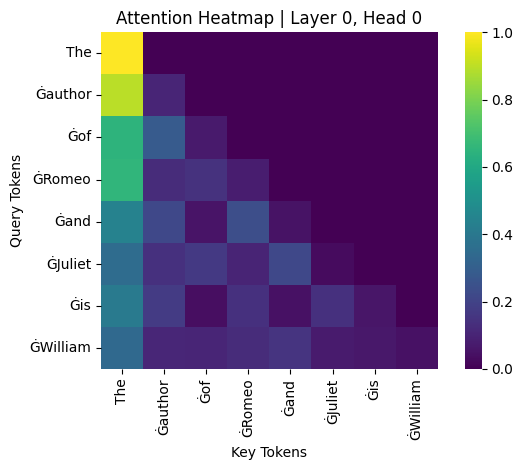

In [24]:
def plot_attention_matrix(att_matrix, tokens, layer=0, head=0):
    attn = att_matrix[layer][0, head].detach().numpy()
    sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap="viridis", square=True, cbar=True)
    plt.title(f"Attention Heatmap | Layer {layer}, Head {head}")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Example: Layer 0, Head 0
plot_attention_matrix(attentions, tokens, layer=0, head=0)


## See most probable next token, entropy and attention at each layer

Prompt: The author of Romeo and Juliet is William

Layer  1: Last Token Entropy 0.2398, Mean Entropy 0.2529
   1:          , (0.9712)
   2:          . (0.0120)
   3:          - (0.0097)
   4:       Ġand (0.0060)
   5:         Ġ" (0.0007)
   6:         's (0.0002)
   7:       Ġthe (0.0002)
   8:         ĠH (0.0000)
   9:          / (0.0000)
  10:         ĠM (0.0000)
Layer  2: Last Token Entropy 0.1796, Mean Entropy 0.4815
   1:          , (0.9787)
   2:          . (0.0129)
   3:          - (0.0062)
   4:         's (0.0014)
   5:       Ġand (0.0008)
   6:         Ġ" (0.0000)
   7:         ĠB (0.0000)
   8:         ĠA (0.0000)
   9:         ĠH (0.0000)
  10:          : (0.0000)
Layer  3: Last Token Entropy 0.0541, Mean Entropy 0.4519
   1:          , (0.9948)
   2:          - (0.0027)
   3:          . (0.0021)
   4:         's (0.0003)
   5:       Ġand (0.0001)
   6:         ĠB (0.0000)
   7:         ĠA (0.0000)
   8:         Ġ" (0.0000)
   9:       Ġthe (0.0000)
  10:          : (0.0000

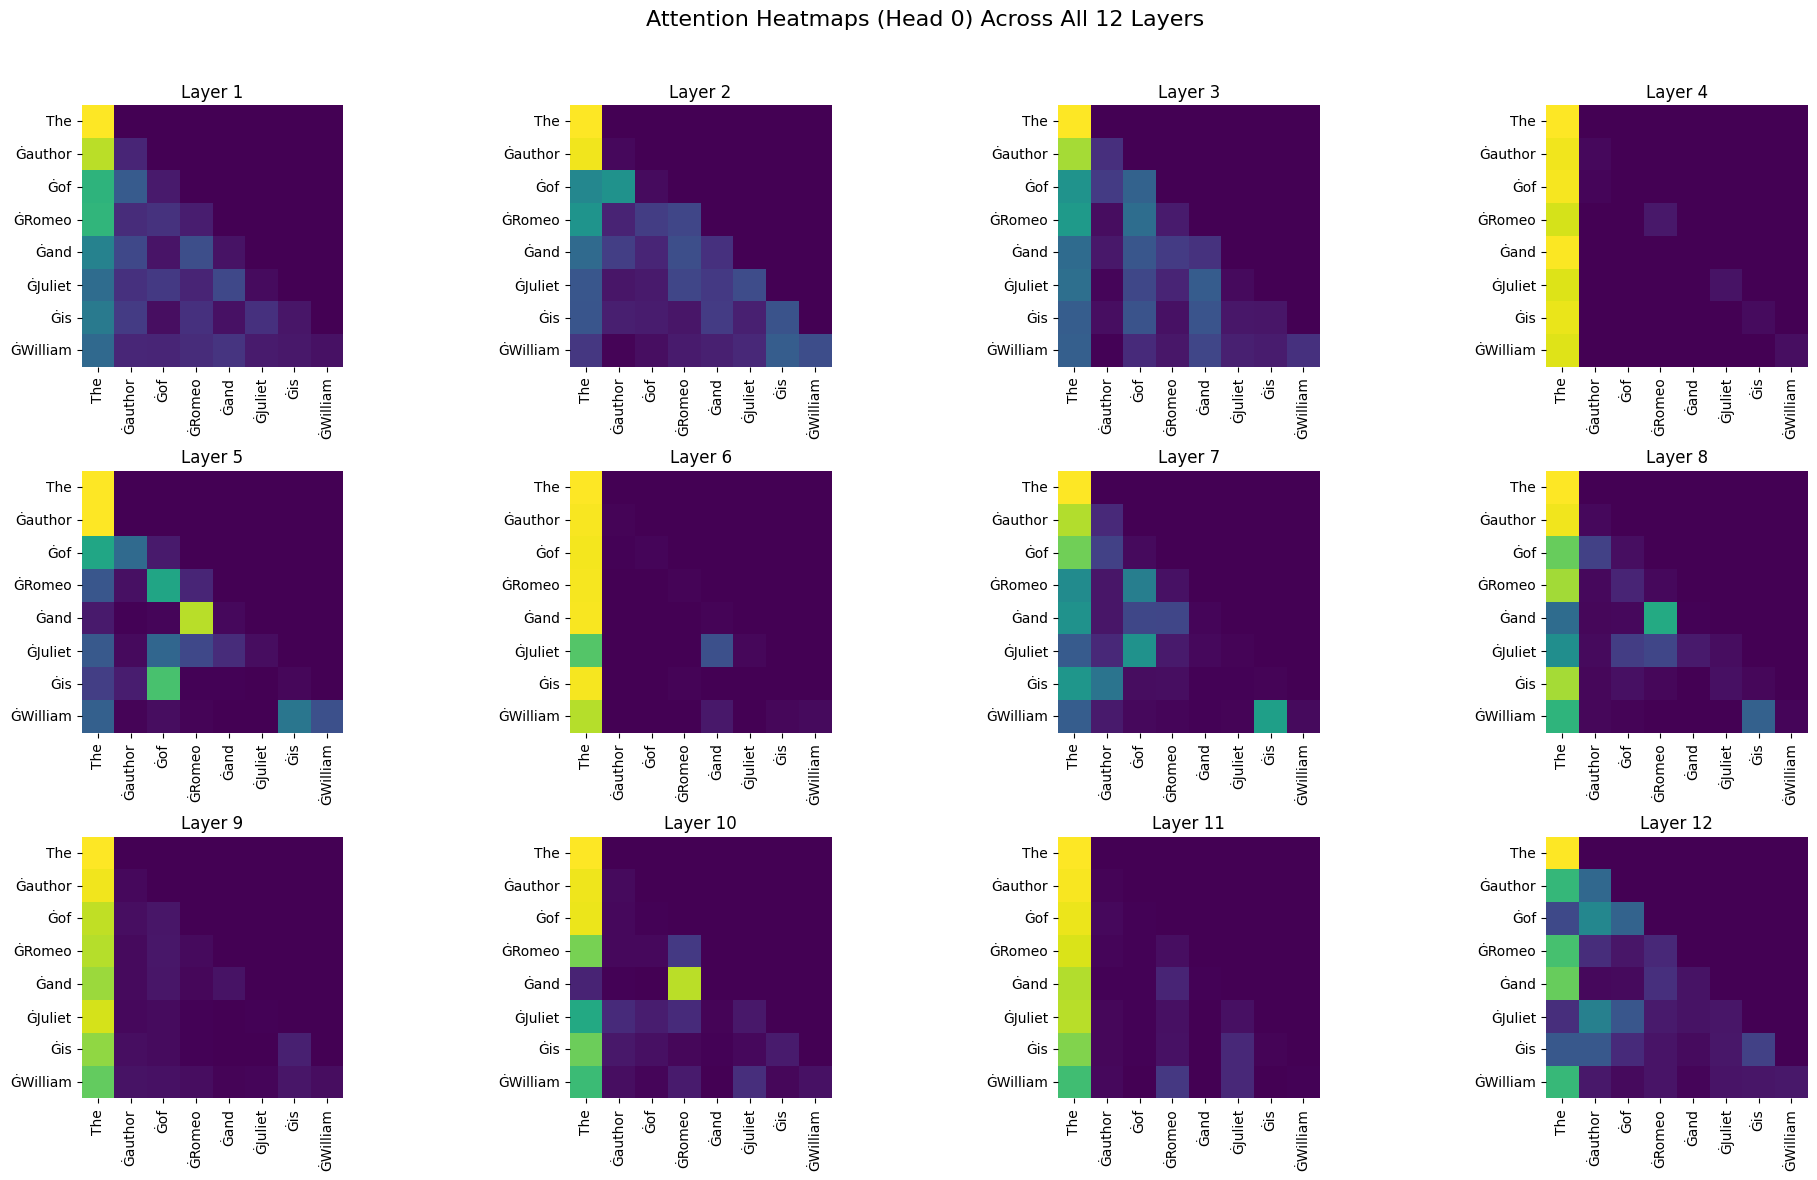

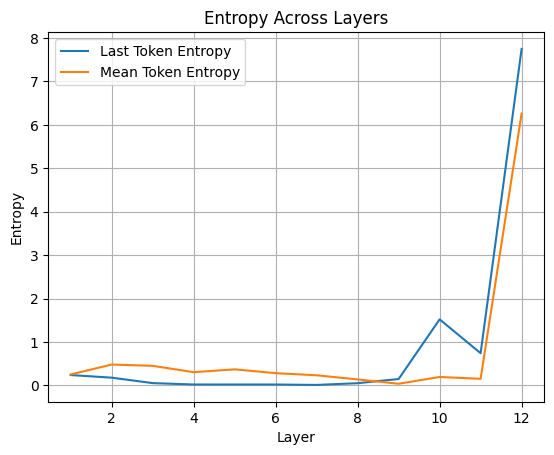

In [36]:
model.eval()

# Input text
prompt = "The author of Romeo and Juliet is William"
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
input_ids = inputs["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])


# Forward pass with hidden states
with torch.no_grad():
    outputs = model(**inputs)

attentions = outputs.attentions  # List of tensors: [layer][batch, head, seq_len, seq_len]

hidden_states = outputs.hidden_states  # Tuple: (embeddings + 12 layers)
n_layers = len(hidden_states)

# Language modeling head
lm_head = model.lm_head  # Linear layer from hidden dim -> vocab size
top_k = 10  # Change as needed
token_position = -1  # Last token in prompt

print(f"Prompt: {prompt}\n")

temperature = 1.0  # Try 0.7 for sharper, or 1.5 for more diverse
entropy_last= []
entropy_mean=[]

for i in range(1, n_layers):  # skip embeddings (index 0)
    
    hidden = hidden_states[i]  # shape: [1, seq_len, hidden_dim]
    last_token_vec = hidden[0, token_position, :]  # shape: [hidden_dim]
    logits = lm_head(last_token_vec)  # shape: [vocab_size]
    # Apply temperature scaling before softmax
    scaled_logits = logits / temperature
    probs = torch.softmax(scaled_logits, dim=-1)
    top_probs, top_ids = torch.topk(probs, top_k)
    top_tokens = tokenizer.convert_ids_to_tokens(top_ids)
    
    mask = probs >0
    entropy = -torch.sum(probs[mask] * torch.log2(probs[mask])).item()
    entropy_last.append(entropy)

    token_vecs = hidden[0]  # shape: [seq_len, hidden_dim]
    all_logits = lm_head(token_vecs)  # shape: [seq_len, vocab_size]
    all_scaled_logits = all_logits / temperature
    all_probs = torch.softmax(all_scaled_logits, dim=-1)  # shape: [seq_len, vocab_size]

    # Compute entropy for each token and average
    a_mask = all_probs > 0
    all_entropy = -torch.sum(all_probs[a_mask] * torch.log2(all_probs[a_mask])).item()
    mean_entropy = all_entropy / all_probs.shape[0]  # average over tokens
    entropy_mean.append(mean_entropy)

    print(f"Layer {i:2d}: Last Token Entropy {entropy:.4f}, Mean Entropy {mean_entropy:.4f}")
    for j in range(top_k):
        print(f"  {j+1:2d}: {top_tokens[j]:>10} ({top_probs[j].item():.4f})")


def plot_attention_layers(attentions, tokens, head_idx=0):
    num_layers = len(attentions)
    seq_len = len(tokens)

    fig, axes = plt.subplots(3, 4, figsize=(20, 12))
    fig.suptitle(f"Attention Heatmaps (Head {head_idx}) Across All 12 Layers", fontsize=16)

    for i in range(num_layers):
        ax = axes[i // 4, i % 4]
        attn = attentions[i][0, head_idx, :, :].detach().numpy()
        sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap="viridis", ax=ax, square=True, cbar=False)
        ax.set_title(f"Layer {i+1}")
        ax.tick_params(axis='x', rotation=90)
        ax.tick_params(axis='y', rotation=0)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Call function
plot_attention_layers(attentions, tokens, head_idx=0)

plt.plot(np.arange(1, n_layers), entropy_last, label="Last Token Entropy")
plt.plot(np.arange(1, n_layers), entropy_mean, label="Mean Token Entropy")
plt.xlabel("Layer")
plt.ylabel("Entropy")
plt.title("Entropy Across Layers")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
def show_attention(attentions, tokens, layer_idx=0, head_idx=0):
    attn = attentions[layer_idx][0, head_idx].detach().numpy()

    plt.figure(figsize=(8, 6))
    sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap="viridis", square=True)
    plt.title(f"Attention Heatmap – Layer {layer_idx+1}, Head {head_idx}")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Widget controls
layer_slider = widgets.IntSlider(value=0, min=0, max=len(attentions)-1, step=1, description='Layer')
head_slider = widgets.IntSlider(value=0, min=0, max=attentions[0].shape[1]-1, step=1, description='Head')

# Interactive display
interactive_plot = widgets.interactive(
    show_attention,
    attentions=widgets.fixed(attentions),
    tokens=widgets.fixed(tokens),
    layer_idx=layer_slider,
    head_idx=head_slider
)

display(interactive_plot)


interactive(children=(IntSlider(value=0, description='Layer', max=11), IntSlider(value=0, description='Head', …

To analyze the dynamics of hidden states across layers, you're essentially exploring how the internal token representations evolve at each layer of the transformer. Here are several ways you can analyze and visualize these dynamics effectively:

1. Cosine Similarity Between Layers -> ROTATIONS OF TOKENS DURING TRANSFORMATION

Measure how the hidden representation of a specific token (e.g., the last token "William") changes across layers.
Cosine similarity is a measure of similarity between two vectors based on the angle between them—not their length. It's commonly used in natural language processing (NLP) to compare how "similar" two token embeddings or hidden states are.

Formula:
For two vectors A and B, the cosine similarity is:

cosine_similarity(𝐴,𝐵)=𝐴⋅𝐵/(∥𝐴∥∥𝐵∥)

1.0 → Vectors point in the same direction → Very similar

0.0 → Vectors are orthogonal (90° apart) → No similarity

–1.0 → Vectors point in opposite directions → Completely dissimilar
​

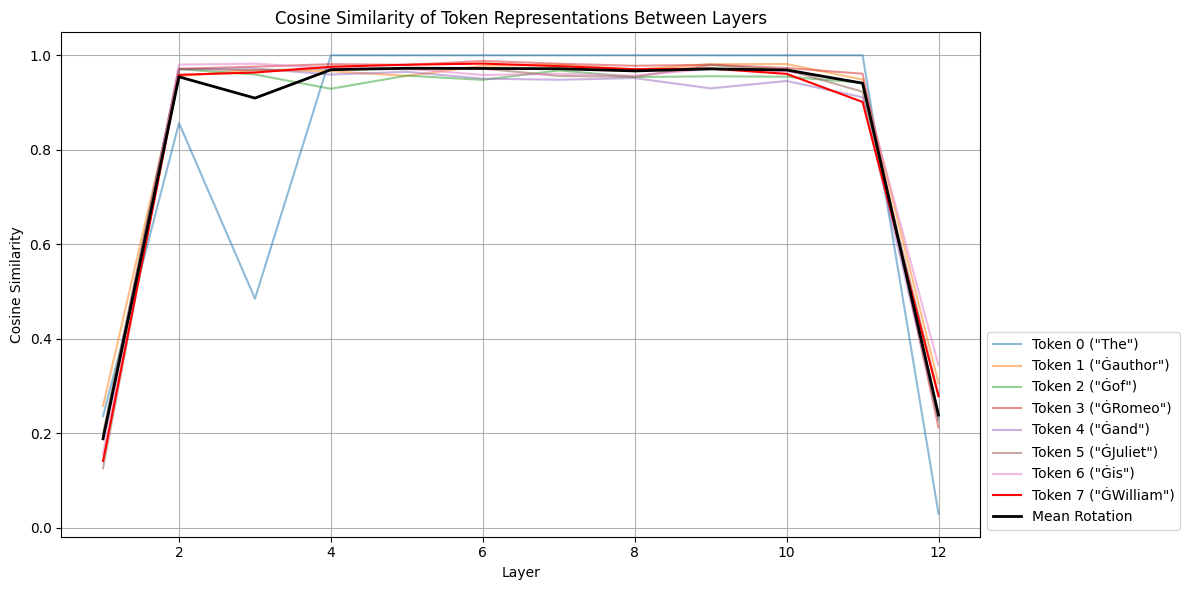

In [39]:
# Store per-token cosine similarities across layers
all_token_rotations = []
mean_rotations = []

seq_len = input_ids.shape[1]

for pos in range(seq_len):
    vectors = [hidden_states[i][0, pos].numpy() for i in range(n_layers)]
    cos_sims = [cosine_similarity([vectors[i]], [vectors[i+1]])[0][0] for i in range(n_layers - 1)]
    all_token_rotations.append(cos_sims)

# Convert to array: shape [seq_len, n_layers - 1]
rot_array = np.array(all_token_rotations)

# Compute mean rotation across tokens at each layer transition
mean_rotations = np.mean(rot_array, axis=0)

# Plot individual token rotations (optional: skip special tokens like [CLS], etc.)
plt.figure(figsize=(12, 6))
for pos in range(seq_len-1):
    plt.plot(range(1, n_layers), rot_array[pos], label=f'Token {pos} ("{tokens[pos]}")', alpha=0.5)

plt.plot(range(1, n_layers), rot_array[-1], label=f'Token {7} ("{tokens[-1]}")', color='red')

# Plot mean rotation
plt.plot(range(1, n_layers), mean_rotations, label='Mean Rotation', color='black', linewidth=2)

plt.title('Cosine Similarity of Token Representations Between Layers')
plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.grid(True)
plt.tight_layout()
plt.show()


1.1. Similarity measures with Target token (for closed prompts)

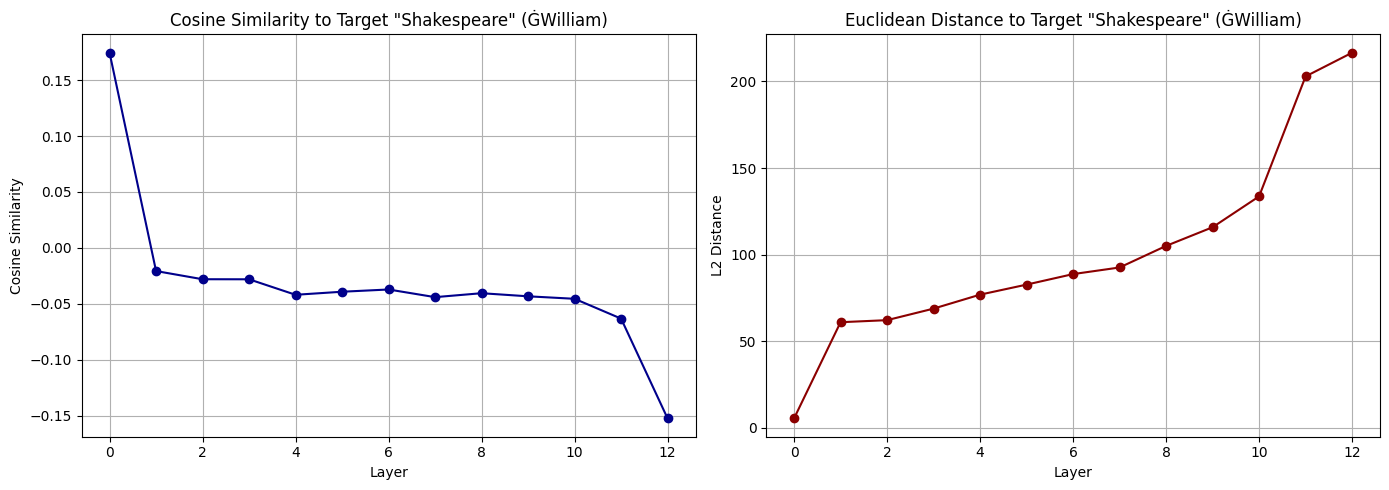

In [43]:
# Get target embedding ("Shakespeare")
target_token = "Shakespeare"
target_id = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(target_token))[0]
with torch.no_grad():
    target_embed = model.get_input_embeddings()(torch.tensor([target_id])).squeeze().numpy()

# Last token position and vectors
token_position = -1
token_label = tokens[token_position]
vectors = [hidden_states[i][0, token_position].numpy() for i in range(n_layers)]

# Compute cosine similarity & Euclidean distance per layer
cos_sims = [cosine_similarity([vec], [target_embed])[0][0] for vec in vectors]
eucl_dists = [np.linalg.norm(vec - target_embed) for vec in vectors]

# Plot both
plt.figure(figsize=(14, 5))

# Cosine similarity plot
plt.subplot(1, 2, 1)
plt.plot(range(n_layers), cos_sims, marker='o', color='darkblue')
plt.title(f'Cosine Similarity to Target "{target_token}" ({token_label})')
plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')
plt.grid(True)

# Euclidean distance plot
plt.subplot(1, 2, 2)
plt.plot(range(n_layers), eucl_dists, marker='o', color='darkred')
plt.title(f'Euclidean Distance to Target "{target_token}" ({token_label})')
plt.xlabel('Layer')
plt.ylabel('L2 Distance')
plt.grid(True)

plt.tight_layout()
plt.show()



Interpretation:
Cosine similarity shows directional alignment — higher means more semantically aligned.

Euclidean distance shows absolute position closeness — lower means closer in space.

We try to repeat the computation with normalized vectors (so distance is no more dependent on magnitude); this often makes cosine and Euclidean inversely correlated on unit vectors (i.e., higher similarity → lower distance).

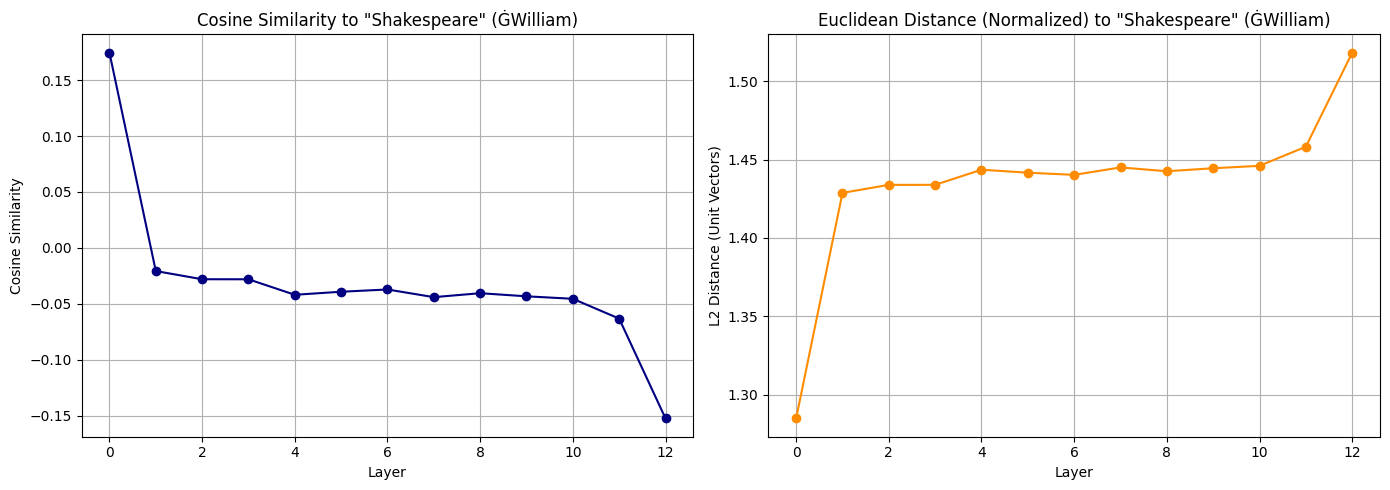

In [45]:
from sklearn.preprocessing import normalize

# Get target embedding ("Shakespeare")
target_token = "Shakespeare"
target_id = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(target_token))[0]
with torch.no_grad():
    target_embed = model.get_input_embeddings()(torch.tensor([target_id])).squeeze().numpy()

# Normalize target embedding
target_embed_norm = normalize(target_embed.reshape(1, -1))[0]

# Last token position and vectors
token_position = -1
token_label = tokens[token_position]
vectors = [hidden_states[i][0, token_position].numpy() for i in range(n_layers)]

# Normalize all vectors
vectors_norm = normalize(np.stack(vectors))

# Compute cosine similarity and Euclidean distance
cos_sims = [cosine_similarity([vec], [target_embed_norm])[0][0] for vec in vectors_norm]
eucl_dists = [np.linalg.norm(vec - target_embed_norm) for vec in vectors_norm]

# Plot
plt.figure(figsize=(14, 5))

# Cosine similarity plot
plt.subplot(1, 2, 1)
plt.plot(range(n_layers), cos_sims, marker='o', color='navy')
plt.title(f'Cosine Similarity to "Shakespeare" ({token_label})')
plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')
plt.grid(True)

# Euclidean distance plot (normalized vectors)
plt.subplot(1, 2, 2)
plt.plot(range(n_layers), eucl_dists, marker='o', color='darkorange')
plt.title(f'Euclidean Distance (Normalized) to "Shakespeare" ({token_label})')
plt.xlabel('Layer')
plt.ylabel('L2 Distance (Unit Vectors)')
plt.grid(True)

plt.tight_layout()
plt.show()


2. Hidden State Norms

See how the magnitude (L2 norm) of token vectors changes with depth. High/low norms can indicate activation saturation or sparsity.

In this context, the L2 norm (or Euclidean norm) of a token’s hidden state vector represents the magnitude or strength of that token’s representation at a given layer.

💡 Intuitively:
A larger norm implies that the model is assigning more "energy" or importance to that token's representation at that layer.

A smaller norm means the token is relatively "suppressed" or not emphasized.

🔍 In Practice:
Early layers may have low norms, as representations are still being built.

Norms often grow in middle layers, as the model encodes more semantic meaning.

In the final layers, norms may peak for important tokens (like names, verbs, or next-token-relevant words).

🔄 Norm + Attention:
High norm and high attention → token is likely critical to model's prediction.

Norm alone doesn’t say what the token means — just that its representation is strong.

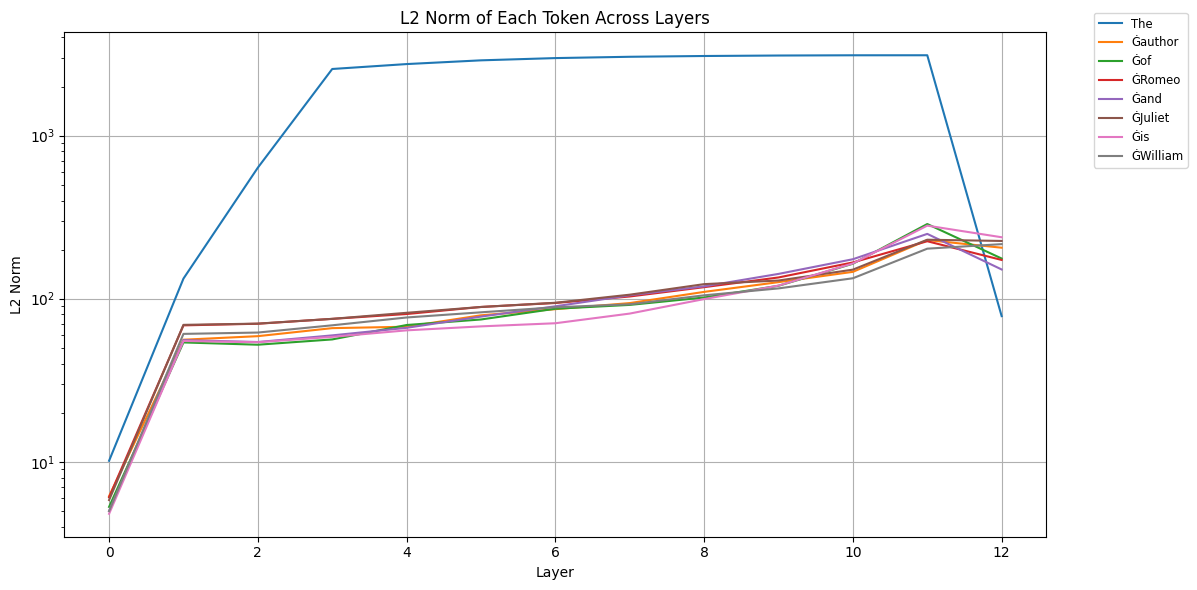

In [ ]:
plt.figure(figsize=(12, 6))

# Plot L2 norm over layers for each token
for token_idx in range(len(tokens)):
    norms = [torch.norm(hidden_states[layer][0, token_idx]).item() for layer in range(n_layers)]
    plt.plot(range(n_layers), norms, label=tokens[token_idx])

plt.title("L2 Norm of Each Token Across Layers")
plt.xlabel("Layer")
plt.ylabel("L2 Norm")
plt.yscale('log')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.05), fontsize='small', ncol=1)
plt.grid(True)
plt.tight_layout()
plt.show()


To compute the volume of a polytope formed by token representations before and after the Feed-Forward Neural Network (FFNN) in a transformer model, you can approximate it using the square root of the determinant of the Gram matrix (a generalization of volume for vector sets in high dimensions).


✅ What You Need:
Hidden states before and after FFNN.


Construct the matrix 𝑉V using token vectors as rows.

Compute 
det(𝑉𝑉^𝑇)  — you might need regularization.

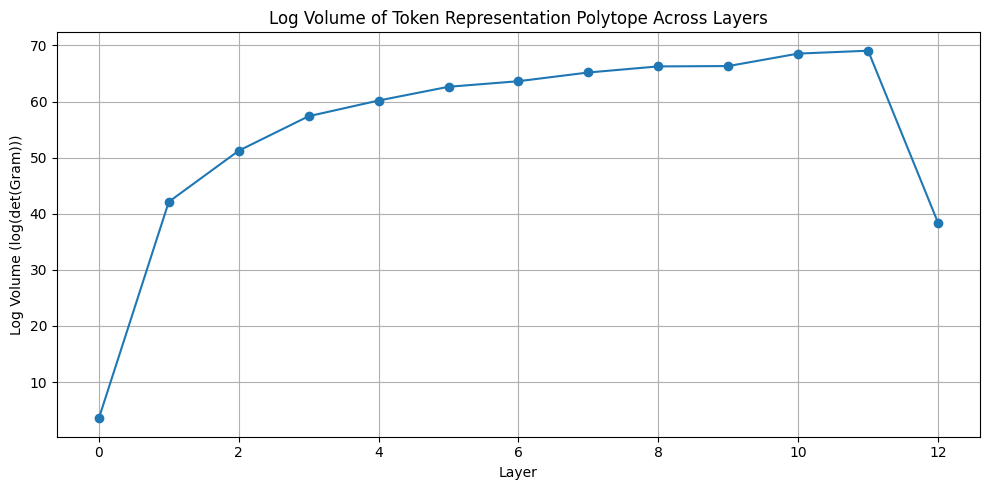

In [57]:
epsilon = 1e-6  # for numerical stability
log_volumes = []

for layer_idx in range(n_layers):
    # Get hidden states for all tokens at this layer (shape: [seq_len, hidden_dim])
    layer_vecs = hidden_states[layer_idx][0]

    # Center the vectors (optional but helps numerical stability)
    centered = layer_vecs - layer_vecs.mean(dim=0)

    # Convert to numpy
    V = centered.detach().cpu().numpy()

    # Compute Gram matrix
    G = V @ V.T  # [seq_len, seq_len]

    # Compute log-volume = log(det(G))
    try:
        log_det = np.linalg.slogdet(G + epsilon * np.eye(G.shape[0]))[1]  # slogdet is more stable
        log_volume = log_det
    except np.linalg.LinAlgError:
        log_volume = float('-inf')  # failed determinant

    log_volumes.append(log_volume)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(range(n_layers), log_volumes, marker='o')
plt.title("Log Volume of Token Representation Polytope Across Layers")
plt.xlabel("Layer")
plt.ylabel("Log Volume (log(det(Gram)))")
plt.grid(True)
plt.tight_layout()
plt.show()


3. Dimensionality Projection (e.g., PCA or t-SNE)

You can visualize the full trajectory of a token in reduced space.


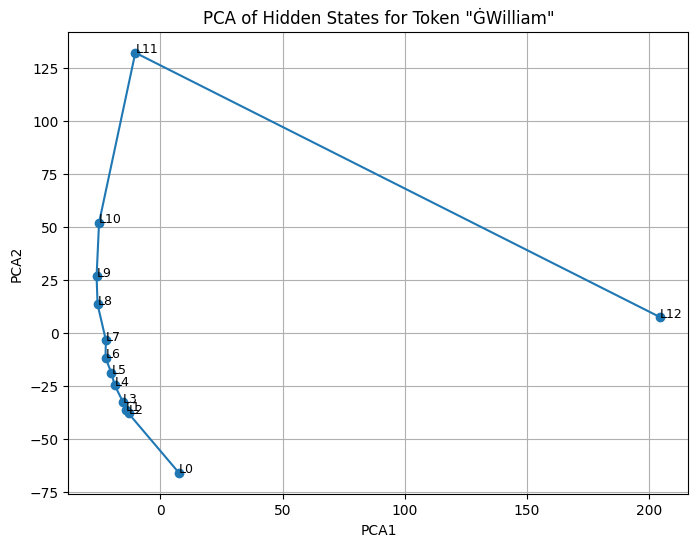

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

plt.figure(figsize=(8, 6))
plt.plot(reduced[:, 0], reduced[:, 1], marker='o')
for i, (x, y) in enumerate(reduced):
    plt.text(x + 0.01, y + 0.01, f'L{i}', fontsize=9)
plt.title(f'PCA of Hidden States for Token "{tokens[token_position]}"')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.show()

4. Compare Multiple Tokens

If you're curious about token interaction (like "William" and "Shakespeare"), you can track their relative positions over layers.

Tracking tokens at positions: [('ĠRomeo', 3), ('ĠJuliet', 5), ('ĠWilliam', 7)]


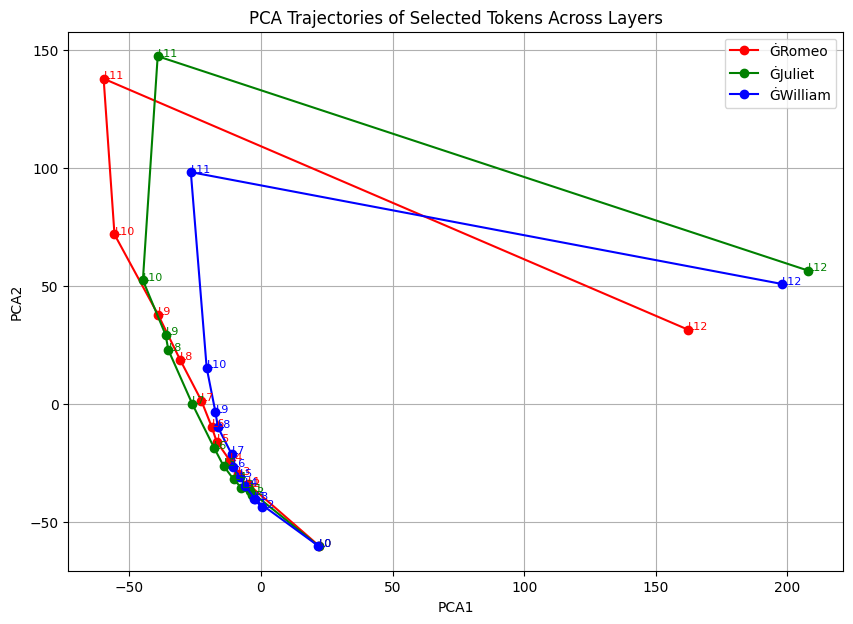

In [30]:
# Choose tokens you want to track
target_tokens = ["Romeo", "Juliet", "William"]
token_indices = [i for i, tok in enumerate(tokens) if any(t in tok for t in target_tokens)]
tracked_tokens = [tokens[i] for i in token_indices]

print("Tracking tokens at positions:", list(zip(tracked_tokens, token_indices)))

token_trajectories = {tok: [] for tok in tracked_tokens}

for i in range(n_layers):
    for tok, idx in zip(tracked_tokens, token_indices):
        vec = hidden_states[i][0, idx].numpy()
        token_trajectories[tok].append(vec)

# Combine all vectors to fit PCA
all_vecs = np.concatenate([token_trajectories[tok] for tok in tracked_tokens], axis=0)
pca = PCA(n_components=2)
all_reduced = pca.fit_transform(all_vecs)

# Split back into token trajectories
offset = 0
token_reduced = {}
for tok in tracked_tokens:
    token_reduced[tok] = all_reduced[offset:offset + n_layers]
    offset += n_layers

# Plot
plt.figure(figsize=(10, 7))
colors = ['red', 'green', 'blue']

for tok, col in zip(tracked_tokens, colors):
    coords = token_reduced[tok]
    x, y = zip(*coords)
    plt.plot(x, y, marker='o', label=tok, color=col)
    for i, (px, py) in enumerate(coords):
        plt.text(px + 0.01, py + 0.01, f'L{i}', fontsize=8, color=col)

plt.title("PCA Trajectories of Selected Tokens Across Layers")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.grid(True)
plt.show()


Tracking tokens at positions: [('ĠRomeo', 3), ('ĠJuliet', 5), ('ĠWilliam', 7)]


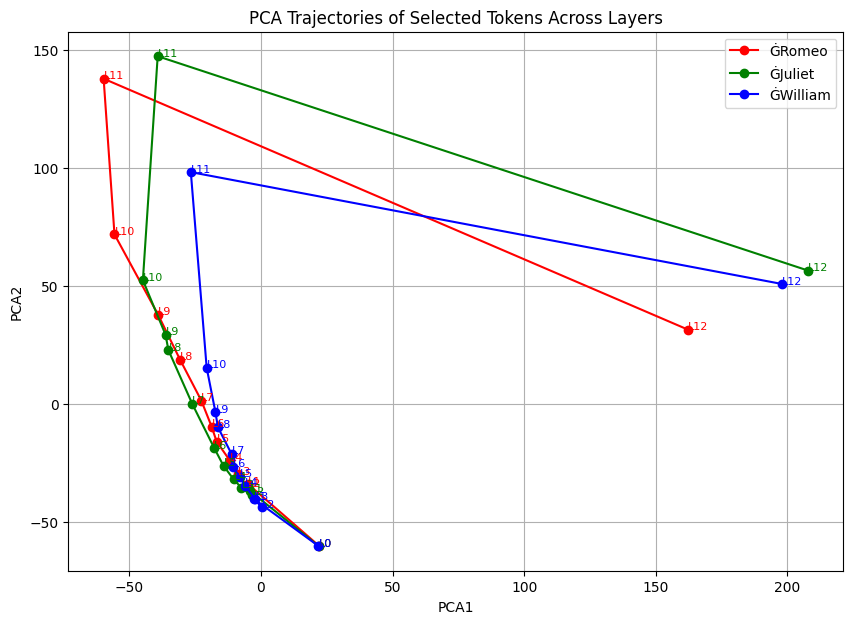

In [58]:
# Choose tokens you want to track
target_tokens = ["Romeo", "Juliet", "William", "Shakespeare"]  # Add "Shakespeare" to target tokens
token_indices = [i for i, tok in enumerate(tokens) if any(t in tok for t in target_tokens)]
tracked_tokens = [tokens[i] for i in token_indices]

print("Tracking tokens at positions:", list(zip(tracked_tokens, token_indices)))

# Collect token trajectories
token_trajectories = {tok: [] for tok in tracked_tokens}

for i in range(n_layers):
    for tok, idx in zip(tracked_tokens, token_indices):
        vec = hidden_states[i][0, idx].numpy()
        token_trajectories[tok].append(vec)

# Combine all vectors to fit PCA
all_vecs = np.concatenate([token_trajectories[tok] for tok in tracked_tokens], axis=0)
pca = PCA(n_components=2)
all_reduced = pca.fit_transform(all_vecs)

# Split back into token trajectories
offset = 0
token_reduced = {}
for tok in tracked_tokens:
    token_reduced[tok] = all_reduced[offset:offset + n_layers]
    offset += n_layers

# Plot
plt.figure(figsize=(10, 7))
colors = ['red', 'green', 'blue', 'orange']  # Added color for "Shakespeare"

for tok, col in zip(tracked_tokens, colors):
    coords = token_reduced[tok]
    x, y = zip(*coords)
    plt.plot(x, y, marker='o', label=tok, color=col)
    for i, (px, py) in enumerate(coords):
        plt.text(px + 0.01, py + 0.01, f'L{i}', fontsize=8, color=col)

plt.title("PCA Trajectories of Selected Tokens Across Layers")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.grid(True)
plt.show()


5. Mean/Variance of All Tokens

See whether the model tends to compress or expand representations globally:

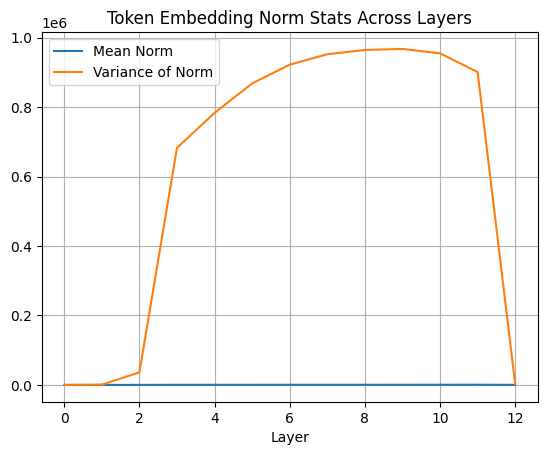

In [31]:
all_norms = [
    torch.norm(hidden_states[i][0], dim=-1).numpy()  # shape: [seq_len]
    for i in range(n_layers)
]

mean_norms = [np.mean(layer_norms) for layer_norms in all_norms]
var_norms = [np.var(layer_norms) for layer_norms in all_norms]

plt.plot(mean_norms, label='Mean Norm')
plt.plot(var_norms, label='Variance of Norm')
plt.title('Token Embedding Norm Stats Across Layers')
plt.xlabel('Layer')
plt.legend()
plt.grid(True)
plt.show()